## Durham Arts and Culture Venues
> Making people aware of the possibilities for cultural activities in an area is always an ongoing problem. I work with the local Historical Society here in Whitby, Durham Region, Ontario, Canada. We want to put an interactive map on our website that shows the location of our museum and other museums, art galleries, and live theater venues in Durham region. 

### 1. Data Collection
> By far the most time consuming part of the project. Foursquare did not provide enough venues of the categories we needed so a web search for more venues was necessary.  
> The categories used were Museum, Art Gallery, and Theater.
> The venue data was stored in a CSV file, read into a dataframe, and the longitudes and latitudes were added. 
### 2. Visualizing the Data
> Once the data was collected and cleaned it was looked at to see how many communities had venues, and how many venues each community had.
### 3. Creating the Map 
> The map has 29 locations marked on it. Each location has a popup label that lists the name, the address, and the phone number of the venue or organization. As well the markers are colour coded for each venue category and there is a legend for that.  



In [2]:

#!pip install geopandas
!pip install geopy
import requests
from geopy.geocoders import Nominatim

import types
import pandas as pd

import numpy as np
!pip install folium
import folium
import csv
from pandas import json_normalize #transform json file into a dataframe

print('imports done')


imports done


## 1. Data Collection
### - The Municipalities in Durham
> There are eight municipalities. These will be used as the centers for collecting venues from Foursquare.

In [2]:
municipalities = ['Ajax Ontario Canada',
                  'Brock Ontario Canada',
                  'Clarington Ontario Canada',
                  'Oshawa Ontario Canada',
                  'Pickering Ontario Canada',
                  'Scugog Ontario Canada',
                  'Uxbridge Ontario Canada',
                  'Whitby Ontario Canada']


#### A short function to retrieve the latitude and longitude for 1 address

In [19]:
# create a locator object
locator = Nominatim(user_agent='myGeocoder')

def get_lat_long(address):
    location = locator.geocode(address)
    if location != None:
        lat = location.latitude
        lon = location.longitude
    else:
        lat = np.nan
        lon = np.nan
    return lat, lon


#### Get the longitude and latitude of the eight municipalities

In [4]:
municipalities_locations = []
for m in municipalities:
    lat, lon = get_lat_long(m)
    municipalities_locations.append([m, lat, lon])
municipalities_locations

[['Ajax Ontario Canada', 43.850374, -79.024658],
 ['Brock Ontario Canada', 44.347685049999995, -79.10016490761303],
 ['Clarington Ontario Canada', 43.96868585, -78.65135738273909],
 ['Oshawa Ontario Canada', 43.91768, -78.862953],
 ['Pickering Ontario Canada', 43.835765, -79.090576],
 ['Scugog Ontario Canada', 44.1150554, -78.90598875892695],
 ['Uxbridge Ontario Canada', 44.1088502, -79.1226768],
 ['Whitby Ontario Canada', 43.899871, -78.940201]]

#### Build a database of venues for all the municipalities

In [5]:

# define foursquare arguments 
client_id ='XXX'
client_secret = 'XXX'
version = '20180605'
limit = 100
radius = 5000

#create an empty dataframe
municipalities_venues = pd.DataFrame()

for lst in municipalities_locations:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        client_id,
        client_secret,
        version,
        lst[1],
        lst[2],
        radius,
        limit)
    results = requests.get(url).json()
    #extract the items
    venues = results['response']['groups'][0]['items']
    #create dataframe
    one_m_venues = json_normalize(venues)
    #add the new dataframe to the collector dataframe
    municipalities_venues = pd.concat([municipalities_venues,one_m_venues], axis=0)

municipalities_venues.shape 


(429, 24)

### - Extract the Relevant Columns

In [6]:
print(municipalities_venues.columns)

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.lat',
       'venue.location.lng', 'venue.location.labeledLatLngs',
       'venue.location.distance', 'venue.location.postalCode',
       'venue.location.cc', 'venue.location.city', 'venue.location.state',
       'venue.location.country', 'venue.location.formattedAddress',
       'venue.categories', 'venue.photos.count', 'venue.photos.groups',
       'venue.venuePage.id', 'venue.location.crossStreet',
       'venue.events.count', 'venue.events.summary',
       'venue.location.neighborhood'],
      dtype='object')


In [7]:
filter_col=['venue.name','venue.location.address','venue.location.city','venue.categories','venue.location.lat','venue.location.lng']
municipalities_venues = municipalities_venues.loc[:,filter_col]
municipalities_venues.head()

,venue.name,venue.location.address,venue.location.city,venue.categories,venue.location.lat,venue.location.lng
0,Debbie's Boutique Cafe,94 Harwood Avenue South,Ajax,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.850183,-79.021350
1,Retro Burger,105 Bayly St W,Ajax,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",43.842269,-79.021905
2,Portly Piper,235 Bayly St W,Ajax,"[{'id': '4bf58dd8d48988d157941735', 'name': 'N...",43.841323,-79.026583
3,Life Time Athletic,100 Beck Crescent,Ajax,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",43.859315,-79.013105
4,Mexico Lindo,200 Harwood Avenue,Ajax,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.848601,-79.021804


### - Get the categories of each venue

In [8]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
#unpack the categories
municipalities_venues['venue.categories']=municipalities_venues.apply(get_category_type, axis=1)
municipalities_venues.head()

,venue.name,venue.location.address,venue.location.city,venue.categories,venue.location.lat,venue.location.lng
0,Debbie's Boutique Cafe,94 Harwood Avenue South,Ajax,Café,43.850183,-79.021350
1,Retro Burger,105 Bayly St W,Ajax,Burger Joint,43.842269,-79.021905
2,Portly Piper,235 Bayly St W,Ajax,New American Restaurant,43.841323,-79.026583
3,Life Time Athletic,100 Beck Crescent,Ajax,Gym,43.859315,-79.013105
4,Mexico Lindo,200 Harwood Avenue,Ajax,Mexican Restaurant,43.848601,-79.021804


In [10]:
#clean the columns
municipalities_venues.columns = [col.split('.')[-1] for col in municipalities_venues.columns]
municipalities_venues.head()

,name,address,city,categories,lat,lng
0,Debbie's Boutique Cafe,94 Harwood Avenue South,Ajax,Café,43.850183,-79.021350
1,Retro Burger,105 Bayly St W,Ajax,Burger Joint,43.842269,-79.021905
2,Portly Piper,235 Bayly St W,Ajax,New American Restaurant,43.841323,-79.026583
3,Life Time Athletic,100 Beck Crescent,Ajax,Gym,43.859315,-79.013105
4,Mexico Lindo,200 Harwood Avenue,Ajax,Mexican Restaurant,43.848601,-79.021804


### - Make sure we do not have duplicate entries since the radiuses may overlap. They had to be large to take in all the rural municipalities. Also remove any Toronto venues that were picked up.

In [11]:
#remove duplicate entries from overlap of radius
municipalities_venues.drop_duplicates(inplace=True)
municipalities_venues.shape

(402, 6)

In [12]:
#make sure we didn't pick up some Toronto locations
indexNames = municipalities_venues[ municipalities_venues['city'] == 'Toronto' ].index
# Delete these row indexes from dataFrame
municipalities_venues.drop(indexNames , inplace=True)
municipalities_venues.shape

(402, 6)

In [13]:
municipalities_venues

,name,address,city,categories,lat,lng
0,Debbie's Boutique Cafe,94 Harwood Avenue South,Ajax,Café,43.850183,-79.021350
1,Retro Burger,105 Bayly St W,Ajax,Burger Joint,43.842269,-79.021905
2,Portly Piper,235 Bayly St W,Ajax,New American Restaurant,43.841323,-79.026583
3,Life Time Athletic,100 Beck Crescent,Ajax,Gym,43.859315,-79.013105
4,Mexico Lindo,200 Harwood Avenue,Ajax,Mexican Restaurant,43.848601,-79.021804
...,...,...,...,...,...,...
94,Petro-Canada,1545 Rossland Rd E,Whitby,Gas Station,43.903605,-78.920766
96,Pita Deli,1600 Champlain Ave,Whitby,Middle Eastern Restaurant,43.873292,-78.905209
97,Denny's,75 Consumers Lane,Whitby,Breakfast Spot,43.869999,-78.911725
98,TD Canada Trust,920 Taunton Rd E,Whitby,Bank,43.925001,-78.915966


In [14]:
municipalities_venues.reset_index(drop=True, inplace = True)
municipalities_venues

,name,address,city,categories,lat,lng
0,Debbie's Boutique Cafe,94 Harwood Avenue South,Ajax,Café,43.850183,-79.021350
1,Retro Burger,105 Bayly St W,Ajax,Burger Joint,43.842269,-79.021905
2,Portly Piper,235 Bayly St W,Ajax,New American Restaurant,43.841323,-79.026583
3,Life Time Athletic,100 Beck Crescent,Ajax,Gym,43.859315,-79.013105
4,Mexico Lindo,200 Harwood Avenue,Ajax,Mexican Restaurant,43.848601,-79.021804
...,...,...,...,...,...,...
397,Petro-Canada,1545 Rossland Rd E,Whitby,Gas Station,43.903605,-78.920766
398,Pita Deli,1600 Champlain Ave,Whitby,Middle Eastern Restaurant,43.873292,-78.905209
399,Denny's,75 Consumers Lane,Whitby,Breakfast Spot,43.869999,-78.911725
400,TD Canada Trust,920 Taunton Rd E,Whitby,Bank,43.925001,-78.915966


### - Find the relevant categories from the list of categories

In [15]:
# make a list of the different categories
cat = municipalities_venues['categories'].unique()
print(len(cat))
cat

110


array(['Café', 'Burger Joint', 'New American Restaurant', 'Gym',
       'Mexican Restaurant', 'Bookstore', 'Restaurant',
       'Afghan Restaurant', 'Sports Bar', 'Coffee Shop', 'Wings Joint',
       'Breakfast Spot', 'Gym / Fitness Center',
       'Middle Eastern Restaurant', 'Grocery Store',
       'Japanese Restaurant', 'Liquor Store', 'Park', 'Warehouse Store',
       'Fast Food Restaurant', 'Garden Center', 'Smoothie Shop',
       'Clothing Store', 'Brewery', 'Ice Cream Shop',
       'Caribbean Restaurant', 'Diner', 'Indian Restaurant',
       'Pizza Place', 'Pet Store', 'Movie Theater', 'Irish Pub',
       'Fried Chicken Joint', 'Pharmacy', 'Comedy Club', 'Poutine Place',
       'Dessert Shop', 'Bakery', 'Sporting Goods Shop', 'Bank',
       'Arts & Crafts Store', 'Furniture / Home Store', 'Discount Store',
       'Department Store', 'Chinese Restaurant', 'Pub', 'Hotel',
       'Big Box Store', 'Electronics Store', 'Music Store',
       'Athletics & Sports', 'Beer Store', 'Sandwi

### - Get the Venues With the Categories Museum, Art Gallery, and Theater

In [16]:
museums = municipalities_venues.loc[municipalities_venues['categories']=='Museum']
museums

,name,address,city,categories,lat,lng
135,Parkwood Estate,270 Simcoe St N,Oshawa,Museum,43.904584,-78.867608


In [17]:
arts = municipalities_venues.loc[municipalities_venues['categories']=='Art Gallery']
arts

,name,address,city,categories,lat,lng
129,The Robert McLaughlin Gallery (@theRMG),72 Queen St,Oshawa,Art Gallery,43.895015,-78.865704


In [18]:
theaters = municipalities_venues.loc[municipalities_venues['categories']=='Theater']
theaters

,name,address,city,categories,lat,lng
115,Oshawa Little Theatre,62 Russett Ave.,Oshawa,Theater,43.930277,-78.880503
154,Regent Theatre,50 King Street East,Oshawa,Theater,43.898317,-78.861939


### - Foursquare came up with only four venues with the relevant categories

In [19]:
arts_df = pd.concat([museums, arts, theaters], axis=0)
arts_df


,name,address,city,categories,lat,lng
135,Parkwood Estate,270 Simcoe St N,Oshawa,Museum,43.904584,-78.867608
129,The Robert McLaughlin Gallery (@theRMG),72 Queen St,Oshawa,Art Gallery,43.895015,-78.865704
115,Oshawa Little Theatre,62 Russett Ave.,Oshawa,Theater,43.930277,-78.880503
154,Regent Theatre,50 King Street East,Oshawa,Theater,43.898317,-78.861939


## More Venues Needed
> With only four venues from Foursquare a web search for more was done. The result was added to the Foursquare venues and we ended up with a total of 32 venues which were stored in a CSV file.  The latitudes and longitudes are not entered yet.

In [25]:
# reading in the csv file

arts_df = pd.read_csv('Durham Data.csv')
arts_df.tail()


,name,address,city,categories,lat,lng,Phone
27,Oshawa Little Theatre,62 Russett Ave,Oshawa,Theater,NaN,NaN,(905) 723-0282
28,Regent Theatre Ontario Tech,50 King St E,Oshawa,Theater,NaN,NaN,(905) 721-3399 ext. 2
29,Oshawa Museum,1450 Simcoe St. South,Oshawa,Museum,NaN,NaN,(905) 436-7624
30,Oshawa Little Theater,62 Russett Ave.,Oshawa,Theater,NaN,NaN,(905) 723 0282
31,Parkwood Estate,270 Simcoe St. North,Oshawa,Museum,NaN,NaN,(905) 433 4311


In [27]:
#change the data types of the lat and lng columnss to float
arts_df[['lat','lng']] = arts_df[['lat','lng']].apply(pd.to_numeric)
arts_df.dtypes

name           object
address        object
city           object
categories     object
lat           float64
lng           float64
Phone          object
dtype: object

### - Find the latitude and longitude for each row in the arts_df

In [29]:

# need to add the city to the address
adds = arts_df['address'].to_list()
cities = arts_df['city'].to_list()
t_adds = [m+' '+n for m,n in zip(adds, cities)]

# start lists for the latitude and longitude
lat_lst =[]
long_lst = []
for ad in t_adds:
    
    lat, lng = get_lat_long(ad)
    
    lat_lst.append(lat)
    long_lst.append(lng)

# add the latitude and longitude to the dataframe
arts_df['lat']= lat_lst
arts_df['lng']= long_lst
arts_df.head()

,name,address,city,categories,lat,lng,Phone
0,Blue Willow Studio,19 Patricia Avenue,Oshawa,Art Gallery,43.901553,-78.849534,905 435-0575
1,Gallery 282 Ltd,321 Northcliffe Ave,Oshawa,Art Gallery,43.917164,-78.884608,905 576-2187
2,Images 21 Art Studio,552 Westney Rd. N,Ajax,Art Gallery,43.868353,-79.039990,(905) 239-6363
3,Magic Door Art Gallery,100 River Street,Sunderland,Art Gallery,54.875990,-1.421068,(705) 357-1973
4,Marc Barrie Gallery,1613 7 Hwy,Brougham,Art Gallery,54.648120,-2.729612,(905) 683-7010


In [40]:
#if any address did not return coordinants, remove any NaN entries
arts_df.dropna(subset = ['lat','lng'], inplace = True)
arts_df.reset_index(drop=True, inplace = True)
arts_df

,name,address,city,categories,lat,lng,Phone
0,Blue Willow Studio,19 Patricia Avenue,Oshawa,Art Gallery,43.901553,-78.849534,905 435-0575
1,Gallery 282 Ltd,321 Northcliffe Ave,Oshawa,Art Gallery,43.917164,-78.884608,905 576-2187
2,Images 21 Art Studio,552 Westney Rd. N,Ajax,Art Gallery,43.868353,-79.039990,(905) 239-6363
3,Magic Door Art Gallery,100 River Street,Sunderland,Art Gallery,54.875990,-1.421068,(705) 357-1973
4,Marc Barrie Gallery,1613 7 Hwy,Brougham,Art Gallery,54.648120,-2.729612,(905) 683-7010
5,Preston Gallery,77 Brock St West,Uxbridge,Art Gallery,44.108679,-79.123945,905-550-8825
6,Ronden Art Gallery,133 Taunton Road West,Oshawa,Art Gallery,43.931302,-78.884629,905 718 9099
7,The LivingRoom Community Art Studio,149 Simcoe Street South,Oshawa,Art Gallery,43.893687,-78.861618,none
8,The Robert McLaughlin Gallery (RMG),72 Queen Street,Oshawa,Art Gallery,43.895721,-78.866684,(905) 576-3000
9,Visual Arts Centre of Clarington,143 Simpson Avenue,Bowmanville,Art Gallery,43.903348,-78.671832,(905) 623-5831


### - We now have 29 venues

In [41]:
# save the dataframe to a csv file so it can be used in future codes

arts_df.to_csv('arts_venues_data.csv')
print('done')

done


# 2. Visualizing the Data

### - How many communities have venues

In [8]:
coms = arts_df['city'].unique()
print('number of communities: ', len(coms))
print('communities are: ', coms)


number of communities:  10
communities are:  ['Oshawa' 'Ajax' 'Sunderland' 'Brougham' 'Uxbridge' 'Bowmanville' 'Whitby'
 'Cannington' 'Orono' 'Greenwood']


### - How many venues for each community

In [9]:
grp_df = arts_df.groupby('city'). size().reset_index(name = 'counts')
grp_df

,city,counts
0,Ajax,3
1,Bowmanville,3
2,Brougham,1
3,Cannington,1
4,Greenwood,1
5,Orono,1
6,Oshawa,16
7,Sunderland,1
8,Uxbridge,2
9,Whitby,3


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

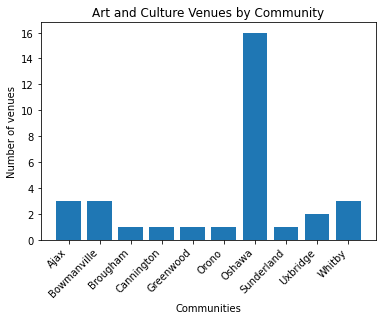

In [11]:
plt.bar(grp_df['city'], grp_df['counts'])
plt.title('Art and Culture Venues by Community')
plt.xlabel('Communities')
plt.ylabel('Number of venues')
plt.xticks(
    rotation=45, 
    horizontalalignment='right'
)

plt.show()


# 3. Creating the Map

### - Find a central point for Durham

In [32]:
locator=Nominatim(user_agent='dh_explorer')
Durham_location = locator.geocode('Durham,Ontario,Canada')
Durham_location

Location(Durham, Oshawa, Durham Region, Golden Horseshoe, Ontario, Canada, (44.0338942, -78.86978798748362, 0.0))

In [33]:
D_lat = Durham_location.latitude
D_lon= Durham_location.longitude
print(D_lat, D_lon)

44.0338942 -78.86978798748362


### - Instantiate map of Durham

In [34]:
map_durham = folium.Map(location=[D_lat, D_lon], 
                        zoom_start =9,
                       )

### - Add legend from picture file

In [35]:
from folium.plugins import FloatImage
image_file = 'legend.PNG'

FloatImage(image_file, bottom=75, left=80).add_to(map_durham)


### - Add a title

In [36]:
loc = 'Durham Art and Culture Venues'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)   

map_durham.get_root().html.add_child(folium.Element(title_html))


### - Add the markers with the popup labels

In [39]:
# add markers
count = 0
for lat, lng, name, address, cat, city, phone in zip(arts_df['lat'], 
                                                     arts_df['lng'],
                                                     arts_df['name'],
                                                     arts_df['address'],
                                                     arts_df['categories'],
                                                     arts_df['city'],
                                                     arts_df['Phone']):
    
    #create the text for the popup labels
    if phone == 'none': #there is no phone number
        lab='''{},<br>
        {}, {}'''.format(name, address, city)
        
    else: #there is a phone number
        lab='''{},<br>
        {}, {}<br>
        {}'''.format(name, address, city, phone)
    
    iframe = folium.IFrame(lab,
                       width=150,
                       height=150)
    
    popup = folium.Popup(iframe,
                     max_width=200)
    
    #select the colours for the icons
    if cat == 'Art Gallery':
        colour = 'blue'
    elif cat == 'Museum':
        colour = 'red'
    else: #only Theater left
        colour = 'green'
   
    #create and add each marker
    folium.Marker(
        [lat, lng],
        radius = 5,
        popup = popup,
        icon=folium.Icon(color=colour,icon = 'fa-asterisk', prefix ='fa'),
        parse_html = False).add_to(map_durham)
    count += 1
print(count)
map_durham

29


### Above map may not show the legend in the npviewer

### - Convert map to HTML file

In [55]:
map_durham.save(outfile = 'Durham map.html')
print('done')

done
